# Data Exploration

In [2]:
import pandas as pd
import cv2
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [3]:
image = cv2.imread('/kaggle/input/lacuna-malaria-detection-dataset/images/id_02i83lum2m.jpg')

In [4]:
height, width, channels = image.shape

print(f'Hight : {height}, Width: {width}, Channels: {channels}')

Hight : 3016, Width: 4032, Channels: 3


In [6]:
# Load dataframe
df = pd.read_csv('/kaggle/input/lacuna-malaria-detection-dataset/Train.csv')

# set base image directory
base_dir = '/kaggle/input/lacuna-malaria-detection-dataset/images/'

# set path for each image in dataframe
df['path'] = df['Image_ID'].apply(lambda x: os.path.join(base_dir, x))

# display new dataframe
df.head(5)

,Image_ID,class,confidence,ymin,xmin,ymax,xmax,path
0,id_u3q6jdck4j.jpg,Trophozoite,1.0,712,1241,737,1270,/kaggle/input/lacuna-malaria-detection-dataset...
1,id_a6cl90trri.jpg,Trophozoite,1.0,558,1566,600,1604,/kaggle/input/lacuna-malaria-detection-dataset...
2,id_qvc2le9sm8.jpg,Trophozoite,1.0,1317,2788,1448,2914,/kaggle/input/lacuna-malaria-detection-dataset...
3,id_w8xnbd5rvm.jpg,Trophozoite,1.0,925,1744,1041,1823,/kaggle/input/lacuna-malaria-detection-dataset...
4,id_6dop09rk02.jpg,NEG,1.0,0,0,0,0,/kaggle/input/lacuna-malaria-detection-dataset...


In [7]:
df['class'].value_counts()

class
Trophozoite    15838
WBC             7004
NEG              688
Name: count, dtype: int64

In [9]:
batch_size = 32
epoch = 5

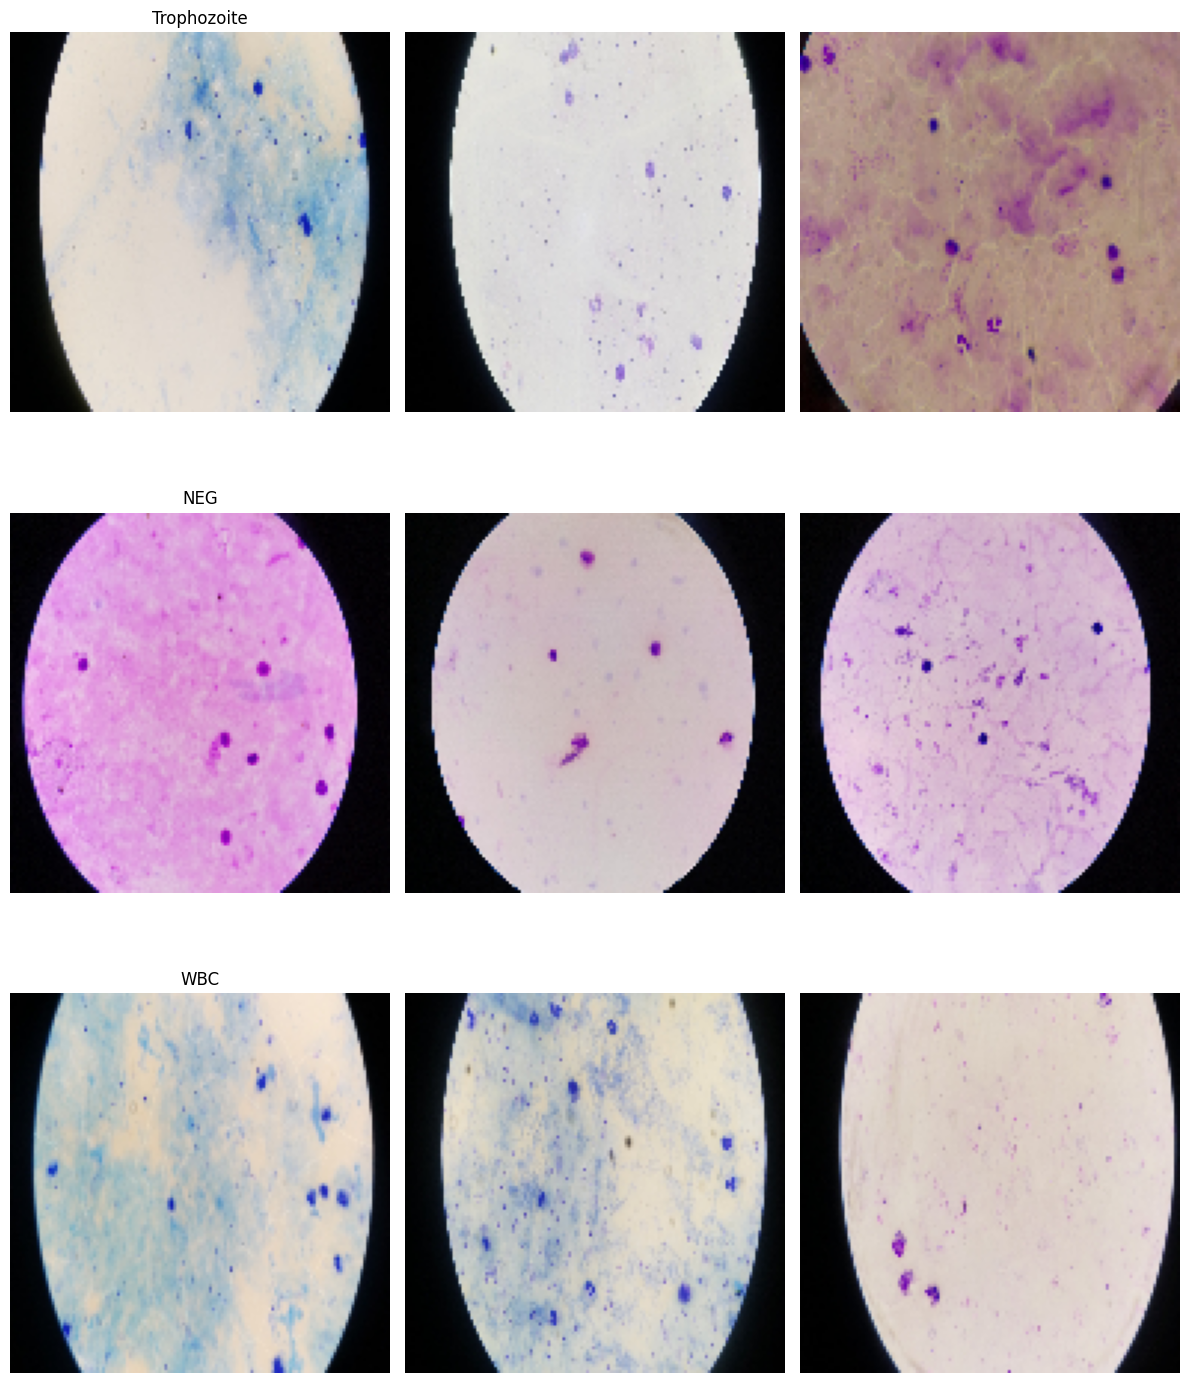

In [8]:
def load_image_and_preprocess(img_path, target_size=(128, 128)):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    img = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # Normalize to [0, 1]
    return img

# Extract unique classes and sample 3 images per class
unique_classes = df["class"].unique()
num_images_per_class = 3

# Plot images
fig, axes = plt.subplots(len(unique_classes), num_images_per_class, figsize=(12, len(unique_classes) * 5))

for i, class_name in enumerate(unique_classes):
    # Filter images of the current class
    class_df = df[df["class"] == class_name]
    # Sample 3 random images from this class
    sampled_df = class_df.sample(num_images_per_class, replace=True)  # 'replace=True' if fewer than 3 images
    sampled_images = [load_image_and_preprocess(path) for path in sampled_df["path"]]

    for j, img in enumerate(sampled_images):
        ax = axes[i, j]
        ax.imshow(img)
        ax.axis('off')
        if j == 0:
            ax.set_title(class_name)  # Add title to the first image of each row

plt.tight_layout()
plt.show()

In [11]:
batch_size = 32
epoch = 5

# Data preparation

In [12]:
# Define the resize function
target_height, target_width = 224, 224  # Specify target size

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 20% of data will be used for validation
)

train_generator = train_datagen.flow_from_dataframe(
    df,
    x_col='path',
    y_col='class',
    target_size=(target_height, target_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training' 
)

validation_generator = train_datagen.flow_from_dataframe(
    df,
    x_col='path',
    y_col='class',
    target_size=(target_height, target_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation' 
)

Found 18824 validated image filenames belonging to 3 classes.
Found 4706 validated image filenames belonging to 3 classes.


In [13]:
# Create an input layer
input_layer = tf.keras.layers.Input(shape=(224, 224, 3))

model = tf.keras.models.Sequential([
  input_layer, 
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),  
  tf.keras.layers.Dense(len(unique_classes), activation= 'softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 173056)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    22,151,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,180,323 (84.61 MB)

 Trainable params: 22,180,323 (84.61 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
history = model.fit(
    train_generator,
    epochs=epoch,
    validation_data=validation_generator,
)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729558042.932074     201 service.cc:145] XLA service 0x7d130c002930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729558042.932217     201 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729558042.932223     201 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/589 ━━━━━━━━━━━━━━━━━━━━ 3:26:52 21s/step - accuracy: 0.3125 - loss: 1.0964

I0000 00:00:1729558048.526634     201 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


589/589 ━━━━━━━━━━━━━━━━━━━━ 1045s 2s/step - accuracy: 0.7056 - loss: 0.7200 - val_accuracy: 0.7459 - val_loss: 0.5089
Epoch 2/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 1017s 2s/step - accuracy: 0.7601 - loss: 0.4900 - val_accuracy: 0.7459 - val_loss: 0.5027
Epoch 3/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 975s 2s/step - accuracy: 0.7710 - loss: 0.4750 - val_accuracy: 0.7431 - val_loss: 0.5062
Epoch 4/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 1007s 2s/step - accuracy: 0.7751 - loss: 0.4658 - val_accuracy: 0.7505 - val_loss: 0.4995
Epoch 5/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 997s 2s/step - accuracy: 0.7762 - loss: 0.4605 - val_accuracy: 0.7531 - val_loss: 0.5027


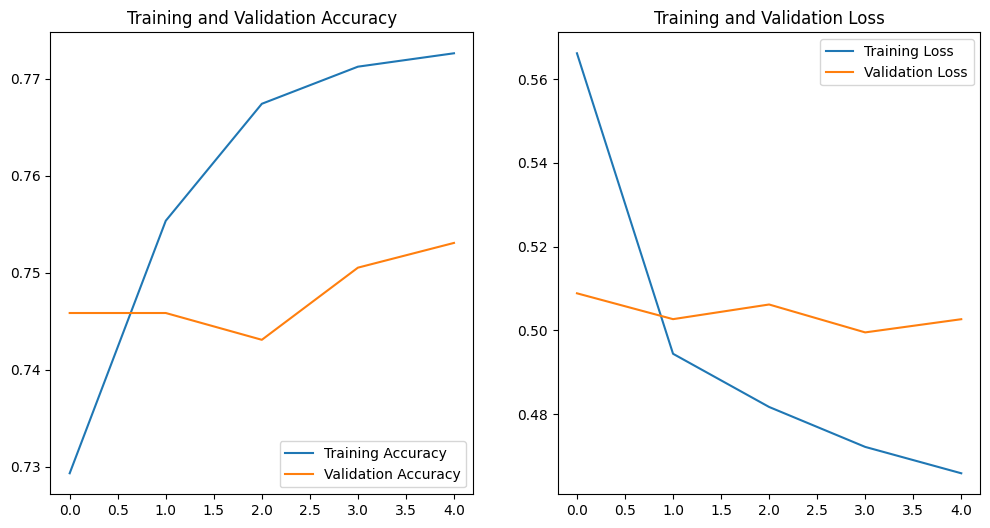

In [18]:
# Get the training and validation metrics from the history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the number of epochs
epochs_range = range(len(acc))

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Show the plots
plt.show()

In [19]:
x_loss, x_acc = model.evaluate(validation_generator)
print(f'Validation accuracy: {x_acc}')
print(f'Validation accuracy: {x_loss}')

148/148 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.7469 - loss: 0.5069
Validation accuracy: 0.753081202507019
Validation accuracy: 0.502673327922821


In [20]:
# Load datatest
test = pd.read_csv('/kaggle/input/lacuna-malaria-detection-dataset/Test.csv')

# set path for each image in dataframe
test['path'] = test['Image_ID'].apply(lambda x: os.path.join(base_dir, x))

# display new dataframe
test.head(3)

,Image_ID,class,confidence,ymin,xmin,ymax,xmax,path
0,id_5n9ov0rr22.jpg,NaN,NaN,NaN,NaN,NaN,NaN,/kaggle/input/lacuna-malaria-detection-dataset...
1,id_k6s11k3klo.jpg,NaN,NaN,NaN,NaN,NaN,NaN,/kaggle/input/lacuna-malaria-detection-dataset...
2,id_eftvcf9djb.jpg,NaN,NaN,NaN,NaN,NaN,NaN,/kaggle/input/lacuna-malaria-detection-dataset...


In [21]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test,
    x_col='path',
    target_size=(target_height, target_width),
    batch_size=batch_size,
    class_mode=None,
)

Found 1178 validated image filenames.


In [22]:
predictions = model.predict(test_generator)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/37 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step


In [25]:
import numpy as np
# Interpret predictions
class_labels = unique_classes
predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = [class_labels[i] for i in predicted_classes]

# Add predicted labels to DataFrame
test['predicted_class'] = predicted_labels

In [26]:
print(test.predicted_class.value_counts())

predicted_class
NEG            741
Trophozoite    295
WBC            142
Name: count, dtype: int64


In [27]:
test[['Image_ID', 'predicted_class']]

,Image_ID,predicted_class
0,id_5n9ov0rr22.jpg,NEG
1,id_k6s11k3klo.jpg,NEG
2,id_eftvcf9djb.jpg,WBC
3,id_kc5tmoj1xa.jpg,Trophozoite
4,id_tirid4qt68.jpg,NEG
...,...,...
1173,id_btrtdkgk4r.jpg,NEG
1174,id_straufuobm.jpg,NEG
1175,id_nnurq35wvp.jpg,WBC
1176,id_hdqd25rput.jpg,WBC
